## 2절. RNN으로 영화평 분류하기

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# 하이퍼 파라미터 설정
MY_WORDS = 10000 # 사전 안의 단어 수
MY_LENGTH = 80 # 영화평 길이, 길면 짜름, 짧으면 제로패딩
MY_EMBED = 32 # 임베딩 차원
MY_HIDDEN = 64 # LSTM 차원
MY_SAMPLE = 5 # 임의의 샘플 데이터
MY_EPOCHS = 10 # 반복 학습 수
MY_BATCH = 200 # 매번 가져오는 데이터 수

np.random.seed(111)

In [3]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=MY_WORDS)

In [4]:
print('학습용 입력 데이터의 모양', X_train.shape)
print('학습용 출력 데이터의 모양', Y_train.shape)
print('평가용 입력 데이터의 모양', X_test.shape)
print('평가용 출력 데이터의 모양', Y_test.shape)

학습용 입력 데이터의 모양 (25000,)
학습용 출력 데이터의 모양 (25000,)
평가용 입력 데이터의 모양 (25000,)
평가용 출력 데이터의 모양 (25000,)


In [5]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
print(len(X_train[0]), len(set(X_train[0])))

218 120


In [7]:
print(Y_train[0])

1


In [8]:
word_to_idx = imdb.get_word_index()

In [9]:
# 가장 많이 사용되는 단어
word_to_idx['the']

1

In [10]:
idx_to_word = dict([(val, key) for (key, val) in word_to_idx.items()])
idx_to_word[1]

'the'

In [11]:
# 인덱스 영화평을 단어 영화평으로 변환
def decoding(review_num):
    decoded = []
    for i in review_num:
        word = idx_to_word[i]
        decoded.append(word)

    return decoded

print(decoding(X_train[0]))

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 

In [12]:
idx_to_word = {k+3 : v for k, v in idx_to_word.items()}
idx_to_word[0] = '<PAD>'
idx_to_word[1] = '<START>'
idx_to_word[2] = '<UNK>' # unknown
idx_to_word[3] = '<UNUSED>'
idx_to_word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [13]:
def show_length():
    print('영화평의 길이')
    for i in range(10):
        print('영화평', i, ':', len(X_train[i]))

show_length()

영화평의 길이
영화평 0 : 218
영화평 1 : 189
영화평 2 : 141
영화평 3 : 550
영화평 4 : 147
영화평 5 : 43
영화평 6 : 123
영화평 7 : 562
영화평 8 : 233
영화평 9 : 130


In [14]:
# 2차원 데이터로 변환하기 위해
# 모든 영화평 길이 같게 해야 함.
X_train = pad_sequences(X_train, maxlen=MY_LENGTH, truncating='post', padding='post')
X_test = pad_sequences(X_test, maxlen=MY_LENGTH, truncating='post', padding='post')

In [15]:
show_length()

영화평의 길이
영화평 0 : 80
영화평 1 : 80
영화평 2 : 80
영화평 3 : 80
영화평 4 : 80
영화평 5 : 80
영화평 6 : 80
영화평 7 : 80
영화평 8 : 80
영화평 9 : 80


In [16]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 30))
mlp.fit(X_train, Y_train)

In [ ]:
mlp.score(X_test, Y_test)

0.50376

In [ ]:
# RNN 구조
model = Sequential()

model.add(Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED, input_length=MY_LENGTH))
model.add(LSTM(MY_HIDDEN, input_shape=(MY_LENGTH, MY_EMBED)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

In [ ]:
begin = time()
model.fit(X_train, Y_train, epochs=MY_EPOCHS, batch_size=MY_BATCH)
end = time()

print(f'training time: {end-begin}')

Epoch 1/10
125/125 [==============================] - 12s 77ms/step - loss: 0.5710 - acc: 0.6810
Epoch 2/10
125/125 [==============================] - 11s 92ms/step - loss: 0.3520 - acc: 0.8510
Epoch 3/10
125/125 [==============================] - 15s 120ms/step - loss: 0.2826 - acc: 0.8872
Epoch 4/10
125/125 [==============================] - 14s 109ms/step - loss: 0.2507 - acc: 0.9058
Epoch 5/10
125/125 [==============================] - 16s 130ms/step - loss: 0.2231 - acc: 0.9182
Epoch 6/10
125/125 [==============================] - 17s 132ms/step - loss: 0.2046 - acc: 0.9250
Epoch 7/10
125/125 [==============================] - 18s 143ms/step - loss: 0.1751 - acc: 0.9379
Epoch 8/10
125/125 [==============================] - 19s 149ms/step - loss: 0.1572 - acc: 0.9456
Epoch 9/10
125/125 [==============================] - 19s 150ms/step - loss: 0.1397 - acc: 0.9508
Epoch 10/10
125/125 [==============================] - 19s 151ms/step - loss: 0.1149 - acc: 0.9622
training time: 159.16

In [ ]:
# 평가용 데이터를 이용한 평가
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print(f'최종 정확도: {score[1]:.2f}')

782/782 [==============================] - 9s 12ms/step - loss: 0.7760 - acc: 0.7689
최종 정확도: 0.77


In [ ]:
# 테스트 데이터를 이용한 긍정/부정 예측
pred = model.predict(X_test)
print(pred)

[[0.03156692]
 [0.99798155]
 [0.98707974]
 ...
 [0.02434686]
 [0.69162285]
 [0.9899094 ]]


In [ ]:
pred = (pred > 0.5)
print('confusion matrix')
print(confusion_matrix(Y_test, pred))

confusion matrix
[[9786 2714]
 [3063 9437]]


In [ ]:
# 실제 텍스트를 이용한 긍정/부정 판별
text = "My God the actors who potrayed the VIP people cannot\
        act. I cringed everytime they said a line. It felt like they\
        were just reading them. Even the intonation was off. It was\
        like when we were kids and had to read a play in class and we\
        exagerated the intonation. Terrible, just awful."

In [ ]:
input_text = text.lower().split()
print(input_text)

['my', 'god', 'the', 'actors', 'who', 'potrayed', 'the', 'vip', 'people', 'cannot', 'act.', 'i', 'cringed', 'everytime', 'they', 'said', 'a', 'line.', 'it', 'felt', 'like', 'they', 'were', 'just', 'reading', 'them.', 'even', 'the', 'intonation', 'was', 'off.', 'it', 'was', 'like', 'when', 'we', 'were', 'kids', 'and', 'had', 'to', 'read', 'a', 'play', 'in', 'class', 'and', 'we', 'exagerated', 'the', 'intonation.', 'terrible,', 'just', 'awful.']


In [ ]:
word_to_idx = imdb.get_word_index()
word_to_idx = {k:(v+3) for k,v in word_to_idx.items()}
word_to_idx["<PAD>"] = 0
word_to_idx["<START>"] = 1
word_to_idx["<UNK>"] = 2 # unknown
word_to_idx["<UNUSED>"] = 3

In [ ]:
# 단어 숫자로 변환
def encoding(review_text):
    encoded = []
    for word in review_text:
        try:
            idx = word_to_idx[word]
            if idx > 10000:
                encoded.append(3)
            else:
                encoded.append(idx)
        except:
            encoded.append(2)
    
    return encoded

input_encoded = encoding(input_text)
print(input_encoded)

[61, 558, 4, 156, 37, 2, 4, 3, 84, 566, 2, 13, 3, 3, 36, 301, 6, 2, 12, 421, 40, 36, 71, 43, 886, 2, 60, 4, 3, 16, 2, 12, 16, 40, 54, 75, 71, 362, 5, 69, 8, 332, 6, 297, 11, 707, 5, 75, 3, 4, 2, 2, 43, 2]


In [ ]:
input_pad = pad_sequences(np.array(input_encoded)[np.newaxis, :], maxlen=MY_LENGTH, truncating='post', padding='post')
model.predict(input_pad)

array([[0.1096836]], dtype=float32)

## 3절. 로이터 기사 분류하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.datasets import reuters

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
MY_SAMPLE = 2947
NUM_CLASS = 46 # 로이터 기사 데이터의 총 카테고리 수
MY_NUM_WORDS = 2000 # 사전 안의 단어의 수
MY_EPOCH = 10 # 학습횟수
MY_BATCH = 64 # 매번 가져와 처리할 데이터의 수
MY_HIDDEN = 512 # 은닉층의 뉴런 수
MY_DROPOUT = 0.5

In [ ]:
labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=MY_NUM_WORDS, test_split=0.3)

2121728/2110848 [==============================] - 0s 0us/step


In [ ]:
def show_shape():
    print('\n== DB SHAPE INFO ==')
    print('X_train shape = ', X_train.shape)
    print('X_test shape = ', X_test.shape)
    print('Y_train shape = ', Y_train.shape)
    print('Y_test shape = ', Y_test.shape)
    
show_shape() 


== DB SHAPE INFO ==
X_train shape =  (7859,)
X_test shape =  (3369,)
Y_train shape =  (7859,)
Y_test shape =  (3369,)


In [ ]:
# 레이블 별 데이터 개수
unique, counts = np.unique(Y_train, return_counts=True)
for i in range(len(unique)):
    print(unique[i], labels[i], '=', counts[i])

0 cocoa = 50
1 grain = 378
2 veg-oil = 66
3 earn = 2769
4 acq = 1701
5 wheat = 14
6 copper = 39
7 housing = 15
8 money-supply = 126
9 coffee = 93
10 sugar = 114
11 trade = 337
12 reserves = 40
13 ship = 149
14 cotton = 18
15 carcass = 19
16 crude = 387
17 nat-gas = 33
18 cpi = 59
19 money-fx = 475
20 interest = 238
21 gnp = 91
22 meal-feed = 10
23 alum = 36
24 oilseed = 56
25 gold = 77
26 tin = 18
27 strategic-metal = 13
28 livestock = 43
29 retail = 19
30 ipi = 38
31 iron-steel = 34
32 rubber = 30
33 heat = 9
34 jobs = 43
35 lei = 10
36 bop = 46
37 zinc = 17
38 orange = 16
39 pet-chem = 20
40 dlr = 32
41 gas = 28
42 silver = 10
43 wpi = 19
44 hog = 10
45 lead = 14


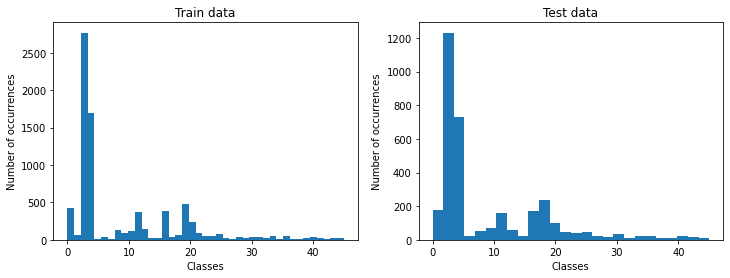

In [ ]:
# 학습용 데이터와 평가용 데이터의 클래스별 개수 시각화
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(Y_train, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Train data')

plt.subplot(122)
plt.hist(Y_test, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Test data')

plt.show()

In [ ]:
# 샘플기사 (2947번) 카테고리와 단어의 수, 실제 데이터 출력
print('article #', MY_SAMPLE)
print('category', Y_train[MY_SAMPLE], labels[Y_train[MY_SAMPLE]])
print('number of words', len(X_train[MY_SAMPLE]))
print(X_train[MY_SAMPLE]) 

article # 2947
category 4 acq
number of words 61
[1, 2, 1229, 81, 8, 16, 515, 25, 270, 5, 4, 2, 1229, 111, 267, 7, 73, 2, 2, 7, 108, 13, 80, 1448, 28, 365, 12, 11, 15, 1986, 2, 69, 158, 18, 1296, 1275, 7, 2, 1627, 2, 2, 4, 393, 374, 1229, 323, 5, 2, 1229, 7, 2, 9, 25, 2, 473, 936, 4, 49, 8, 17, 12]


In [ ]:
# 단어-인덱스 정보 불러옴
word_to_idx = reuters.get_word_index()

print(f'딕셔너리에 {len(word_to_idx) + 1}개 단어 존재함.')
print(f'단어 the 의 인덱스: {word_to_idx["the"]}')

565248/550378 [==============================] - 0s 0us/step
딕셔너리에 30980개 단어 존재함.
단어 the 의 인덱스: 1


In [ ]:
# 단어-인덱스 => 인덱스-단어 딕셔너리 변환
idx_to_word = dict([(val, key) for (key, val) in idx_to_word.items()])

In [ ]:
# 인덱스를 문자로 디코딩
def decoding():
    decoded = []
    for i in X_train[MY_SAMPLE]:
        word = idx_to_word.get(i-3, '???')
        decoded.append(word)

    return decoded

print(decoding())

['???', '???', 'south', 'bad', 'and', 'i', 'genre', 'film', 'looking', '<UNK>', '<START>', '???', 'south', 'films', 'believe', 'the', 'can', '???', '???', 'the', 'characters', 'br', 'been', 'bed', 'you', 'kids', 'is', 'to', 'it', 'm', '???', 'really', 'thing', 'that', 'beautifully', 'army', 'the', '???', 'professional', '???', '???', '<START>', 'episode', 'truly', 'south', 'half', '<UNK>', '???', 'south', 'the', '???', 'a', 'film', '???', '4', 'deep', '<START>', 'out', 'and', 'this', 'is']


In [ ]:
tok = Tokenizer(num_words=MY_NUM_WORDS)
X_train_tok = tok.sequences_to_matrix(X_train, mode='count')
X_test_tok = tok.sequences_to_matrix(X_test, mode='count')

In [ ]:
sample = X_train_tok[MY_SAMPLE]
# print(*sample, sep=' ')
print('array size: ', len(sample))
print('sum: ', np.sum(sample))

array size:  2000
sum:  61.0


In [ ]:
# 단순 은닉층 갖는 DNN
model = Sequential()

model.add(Dense(MY_HIDDEN, input_shape=(MY_NUM_WORDS,)))
model.add(Activation("relu"))
model.add(Dropout(MY_DROPOUT))

model.add(Dense(NUM_CLASS))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               1024512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 46)                23598     
                                                                 
 activation_1 (Activation)   (None, 46)                0         
                                                                 
Total params: 1,048,110
Trainable params: 1,048,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.fit(X_train_tok, Y_train, validation_data=(X_test_tok, Y_test), epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)

Epoch 1/10
123/123 [==============================] - 2s 9ms/step - loss: 1.6425 - accuracy: 0.6696 - val_loss: 1.0820 - val_accuracy: 0.7744
Epoch 2/10
123/123 [==============================] - 1s 8ms/step - loss: 0.8293 - accuracy: 0.8198 - val_loss: 0.9364 - val_accuracy: 0.7925
Epoch 3/10
123/123 [==============================] - 1s 7ms/step - loss: 0.5739 - accuracy: 0.8708 - val_loss: 0.8772 - val_accuracy: 0.8145
Epoch 4/10
123/123 [==============================] - 1s 7ms/step - loss: 0.4301 - accuracy: 0.8987 - val_loss: 0.8780 - val_accuracy: 0.8100
Epoch 5/10
123/123 [==============================] - 1s 7ms/step - loss: 0.3359 - accuracy: 0.9206 - val_loss: 0.8992 - val_accuracy: 0.8175
Epoch 6/10
123/123 [==============================] - 1s 7ms/step - loss: 0.2854 - accuracy: 0.9317 - val_loss: 0.9105 - val_accuracy: 0.8127
Epoch 7/10
123/123 [==============================] - 1s 7ms/step - loss: 0.2397 - accuracy: 0.9406 - val_loss: 0.9393 - val_accuracy: 0.8100
Epoch 

In [ ]:
sample = X_train_tok[MY_SAMPLE]
sample = sample.reshape(1, sample.shape[0])

pred = model.predict(sample, verbose=0)
guess = np.argmax(pred)
answer = Y_train[MY_SAMPLE]

print("샘플 기사의 예측값:", guess, labels[guess])
print("실제 정답:", answer, labels[answer])

샘플 기사의 예측값: 4 acq
실제 정답: 4 acq


In [ ]:
model.evaluate(X_test_tok, Y_test)

106/106 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 0.8121


[0.986157238483429, 0.812110424041748]

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(MY_HIDDEN,), solver="adam", activation="relu", max_iter=10)
mlp.fit(X_train_tok, Y_train)

C:\Users\ameli\anaconda3\envs\saltlux_deep_lecture\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(512,), max_iter=10)

In [ ]:
mlp.predict(sample)

array([4], dtype=int64)

In [ ]:
mlp.score(X_test_tok, Y_test)

0.796675571386168

## 4절. 영-한 번역기

In [1]:
import numpy as np
import pandas as pd

from numpy.random import randint
from time import time
from keras.layers import Input, LSTM, Dense
from keras.models import Model

In [2]:
MY_HIDDEN = 128 # 은닉층의 뉴런의 수
MY_EPOCHS = 500 # 학습횟수 하이퍼 파라미터

In [3]:
# 영문자와 한글 문자를 연결한 알파벳/문자 데이터 생성
arr1 = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
arr2 = pd.read_csv('datasets/korean.csv', header=None)
arr2 = arr2[0].values.tolist()
num_to_char = arr1 + arr2
len(num_to_char)

171

In [4]:
# 각 알파벳/문자에 엔덱스 부여
char_to_num = {n : i for i, n in enumerate(num_to_char)}
n_input = len(char_to_num)

print('글자 사전\n', char_to_num)
print(f'총 글자 수: {len(char_to_num)}')
print(f'영어 글자 수: {len(arr1)}')
print(f'한글 글자 수: {len(arr2)}')

글자 사전
 {'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '싸

In [5]:
raw = pd.read_csv('datasets/translate.csv', header=None)
eng_kor = raw.values.tolist()

print('사전 내용\n', eng_kor)
print('총 단어 수: ', len(eng_kor))

사전 내용
 [['cold', '감기'], ['come', '오다'], ['cook', '요리'], ['copy', '복사'], ['cost', '비용'], ['date', '날짜'], ['deal', '거래'], ['deep', '깊은'], ['desk', '책상'], ['down', '아래'], ['dust', '먼지'], ['duty', '의무'], ['each', '각각'], ['east', '동쪽'], ['easy', '쉽다'], ['exit', '탈출'], ['face', '얼굴'], ['fact', '사실'], ['fall', '가을'], ['farm', '농장'], ['feet', '다리'], ['find', '찾다'], ['fine', '좋다'], ['fish', '생선'], ['flow', '흐름'], ['fund', '기금'], ['gain', '수익'], ['game', '놀이'], ['gift', '선물'], ['girl', '소녀'], ['give', '주다'], ['goal', '목적'], ['gray', '회색'], ['hair', '머리'], ['harm', '피해'], ['hell', '지옥'], ['help', '도움'], ['high', '높은'], ['hole', '구멍'], ['hope', '소망'], ['hour', '시각'], ['join', '합류'], ['kiss', '키스'], ['knee', '무릎'], ['lady', '부인'], ['late', '늦은'], ['left', '왼쪽'], ['life', '생명'], ['loss', '손해'], ['love', '사랑'], ['luck', '행운'], ['mail', '우편'], ['male', '남자'], ['many', '많은'], ['meal', '식사'], ['meat', '고기'], ['menu', '메뉴'], ['milk', '우유'], ['name', '이름'], ['news', '뉴스'], ['next', '다음'], ['once', '한번'], 

In [6]:
# 영어와 한글 인코딩 입력, 디코딩 입력, 디코딩 출력으로 변환
def encode(eng_kor):
    enc_in = []
    dec_in = []
    rnn_out = []

    for seq in eng_kor:
        eng = [char_to_num[c] for c in seq[0]]
        enc_in.append(np.eye(n_input)[eng])

        kor = [char_to_num[c] for c in ('S'+seq[1])]
        dec_in.append(np.eye(n_input)[kor])

        target = [char_to_num[c] for c in (seq[1]+'E')]
        rnn_out.append(target)

    enc_in = np.array(enc_in)
    dec_in = np.array(dec_in)
    rnn_out = np.array(rnn_out)

    # 3차원 구조로 변환
    rnn_out = np.expand_dims(rnn_out, axis=2)

    return enc_in, dec_in, rnn_out

In [7]:
sample = [['word', '단어']]
enc_in, dec_in, rnn_out = encode(sample)

In [8]:
# 인코더 입력 값 샘플 출력
print('\n인코더 입력 값 샘플')
print('데이터 모양:', enc_in.shape)
print(enc_in)

for i in range(4):
    char = np.argmax(enc_in[0, i])
    print(num_to_char[char])


인코더 입력 값 샘플
데이터 모양: (1, 4, 171)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [9]:
# 디코더 입력 값 샘플 출력
print('\n디코더 입력 값 샘플')
print('데이터 모양:', dec_in.shape)
print(dec_in)

for i in range(3):
    char = np.argmax(dec_in[0, i])
    print(num_to_char[char])


디코더 입력 값 샘플
데이터 모양: (1, 3, 171)
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [10]:
# RNN 출력 값 샘플 출력
print('\nRNN 출력 값 샘플')
print('데이터 모양:', rnn_out.shape)
print(rnn_out)

for i in range(3):
    num = rnn_out[0, i, 0]
    print(num_to_char[num])


RNN 출력 값 샘플
데이터 모양: (1, 3, 1)
[[[ 61]
  [114]
  [  1]]]
단
어
E


In [11]:
X_enc, X_dec, Y_rnn = encode(eng_kor)

print('인코더 입력값 모양', X_enc.shape)
print('디코더 입력값 모양', X_dec.shape)
print('출력값 모양', Y_rnn.shape)

인코더 입력값 모양 (110, 4, 171)
디코더 입력값 모양 (110, 3, 171)
출력값 모양 (110, 3, 1)


In [12]:
# LSTM을 이용한 인공신경망 모형 정의
enc_IN = Input(shape=(4, n_input))
_, state_h, state_c = LSTM(units=MY_HIDDEN, return_state=True)(enc_IN)

link = [state_h, state_c]

dec_IN = Input(shape=(3, n_input))
dec_Y1 = LSTM(units=MY_HIDDEN, return_sequences=True)(dec_IN, initial_state=link)
dec_Y2 = Dense(units=n_input, activation='softmax')(dec_Y1)

model = Model(inputs=[enc_IN, dec_IN], outputs=dec_Y2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        153600      ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [14]:
begin = time()
model.fit([X_enc, X_dec], Y_rnn, epochs=MY_EPOCHS)
end = time()
print(f'training time: {(end-begin): .2f}초')

Epoch 1/500
4/4 [==============================] - 3s 6ms/step - loss: 5.1296
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 5.0867
Epoch 3/500
4/4 [==============================] - 0s 6ms/step - loss: 5.0297
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 4.9334
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 4.7456
Epoch 6/500
4/4 [==============================] - 0s 6ms/step - loss: 4.3477
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 3.6749
Epoch 8/500
4/4 [==============================] - 0s 13ms/step - loss: 3.5566
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 3.5758
Epoch 10/500
4/4 [==============================] - 0s 6ms/step - loss: 3.4000
Epoch 11/500
4/4 [==============================] - 0s 6ms/step - loss: 3.3835
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 3.3816
Epoch 13/500
4/4 [==============================] - 0s 6ms/

In [15]:
pick = randint(0, len(eng_kor), 5)
choose = [eng_kor[i] for i in pick]

In [16]:
try_this = [['love', 'PP'], ['olve', 'PP'], ['lvoe', 'PP'], ['loev', 'PP'], ['eovl', 'PP']]
new_data = choose + try_this
new_data

[['rest', '휴식'],
 ['male', '남자'],
 ['when', '언제'],
 ['menu', '메뉴'],
 ['wife', '아내'],
 ['love', 'PP'],
 ['olve', 'PP'],
 ['lvoe', 'PP'],
 ['loev', 'PP'],
 ['eovl', 'PP']]

In [17]:
enc_in, dec_in, _ = encode(new_data)
pred = model.predict([enc_in, dec_in])
print(f'예측 결과의 모양: {pred.shape}')

예측 결과의 모양: (10, 3, 171)


In [18]:
# 예측 결과에서 한글 추출
for i in range(len(new_data)):
    eng = new_data[i][0]
    word = np.argmax(pred[i], axis=1)
    kor = ''
    for j in range(2):
        kor = kor + num_to_char[word[j]]
    
    print(eng, '=>', kor)

rest => 휴식
male => 남자
when => 언제
menu => 메뉴
wife => 아내
love => 사랑
olve => 사E
lvoe => 사사
loev => 사E
eovl => 도리


## 5절. BBC 기사 분류하기

In [1]:
# 데이터 전처리
import csv
import numpy as np
from time import time

import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding
from keras.layers import Bidirectional

In [2]:
# 하이퍼 파라미터 정의
MY_WORDS = 5000 # 사전 안의 단어 수
MY_EMBED = 64 # 임베딩 출력 차원
MY_HIDDEN = 100 # RNN 뉴런의 개수 규모
MY_LEN = 200 # 기사 길이

MY_SPLIT = 0.8 # 학습용 데이터의 비율
MY_SAMPLE = 123 # 임의의 샘플 기사
MY_EPOCH = 10 # 반복 학습 수

In [3]:
# 기사 원본과 전처리한 데이터 그리고 카테고리 라벨 저장할 변수 선언
original = [] # 기사 원본
processed = [] # 전처리된 기사
labels = [] # 기사 카테고리 라벨

In [4]:
# 데이터 분석에서 사용하지 않을 단어, 불용어 불러옴
MY_STOP = set(nltk.corpus.stopwords.words('english'))

print(f'불용어 수: {len(MY_STOP)}')
print(MY_STOP)

불용어 수: 179
{'by', 'if', "you're", 'how', 'while', 'more', 'through', 'do', 'each', 'them', 'other', 'nor', 'once', 'to', 'there', 'only', 'any', 'you', 'now', 'myself', 'd', 'an', "mustn't", 'our', 'here', 'wouldn', 'own', "weren't", 'they', 'after', "that'll", 'under', 're', 'doesn', 'will', "hadn't", 'am', 'was', 'too', 'o', 'mightn', 'during', "don't", 'ourselves', 'which', 'against', 'in', 'than', 'his', "needn't", 'when', 'hasn', 'don', 'mustn', "shan't", 'some', 'above', 'with', 'll', 'but', 'its', 'until', 'herself', 'itself', 'that', "aren't", 'being', 'wasn', 'y', 'why', "hasn't", 'as', "won't", 'for', 'we', "you'd", 'hers', 'further', 'aren', 'their', 'should', 'below', 'yours', 've', 'yourselves', 'her', 'those', 'can', 'him', 'i', 'm', 't', "isn't", 'at', 'all', 'such', 'is', 'your', 'about', 'so', "she's", 'did', 'and', 'into', 'both', 'where', 'were', 'isn', "mightn't", 'what', 'she', 'having', "you'll", 'be', "you've", 'the', 'doing', 'over', 'whom', 'again', 'didn', "it

In [5]:
# 불용어에 해당하는 단어 삭제 후 별도 변수에 저장
with open('datasets/bbc-text.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader) # 첫 번째 행(열 이름) 건너뛰기
    for row in reader:
        labels.append(row[0]) # 라벨
        original.append(row[1]) # 원본 텍스트

        news = row[1]
        for word in MY_STOP:
            token = ' ' + word + ' '
            news = news.replace(token, ' ')

        processed.append(news) # 불용어가 삭제된 텍스트

print(len(original))
print(len(processed))

2225
2225


In [6]:
sample = original[MY_SAMPLE]
print('불용어 삭제 전 샘플 기사')
print(sample)
print(f'카테고리: {labels[MY_SAMPLE]}')
print(f'단어 수: {len(sample.split())}')

불용어 삭제 전 샘플 기사
screensaver tackles spam websites net users are getting the chance to fight back against spam websites  internet portal lycos has made a screensaver that endlessly requests data from sites that sell the goods and services mentioned in spam e-mail. lycos hopes it will make the monthly bandwidth bills of spammers soar by keeping their servers running flat out. the net firm estimates that if enough people sign up and download the tool  spammers could end up paying to send out terabytes of data.   we ve never really solved the big problem of spam which is that its so damn cheap and easy to do   said malte pollmann  spokesman for lycos europe.  in the past we have built up the spam filtering systems for our users   he said   but now we are going to go one step further.    we ve found a way to make it much higher cost for spammers by putting a load on their servers.  by getting thousands of people to download and use the screensaver  lycos hopes to get spamming websites consta

In [7]:
print('불용어 삭제 후 샘플 기사')
sample = processed[MY_SAMPLE]
print(sample)
print('단어 수:', len(sample.split()))

불용어 삭제 후 샘플 기사
screensaver tackles spam websites net users getting chance fight back spam websites  internet portal lycos made screensaver endlessly requests data sites sell goods services mentioned spam e-mail. lycos hopes make monthly bandwidth bills spammers soar keeping servers running flat out. net firm estimates enough people sign download tool  spammers could end paying send terabytes data.   never really solved big problem spam damn cheap easy   said malte pollmann  spokesman lycos europe.  past built spam filtering systems users   said   going go one step further.    found way make much higher cost spammers putting load servers.  getting thousands people download use screensaver  lycos hopes get spamming websites constantly running almost full capacity. mr pollmann said intention stop spam websites working subjecting much data cope with. said screensaver carefully written ensure amount traffic generated user overload web.  every single user contribute three four megabytes per 

In [8]:
# 불용어가 삭제된 데이터 토큰화
A_token = Tokenizer(num_words=MY_WORDS, oov_token='OOV')

A_token.fit_on_texts(processed)
A_tokenized = A_token.texts_to_sequences(processed)

maxlen = max([len(x) for x in A_tokenized])
minlen = min([len(x) for x in A_tokenized])

print('토큰화 결과')
print(f'총 단어 수: {len(A_token.word_counts)}')
print(f'가장 긴 기사: {maxlen}')
print(f'가장 짧은 기사: {minlen}')

토큰화 결과
총 단어 수: 29698
가장 긴 기사: 2279
가장 짧은 기사: 50


In [9]:
# 기사 길이 모두 200으로 통일
# 가장 많이 나오는 단어의 인덱스는 1
A_tokenized = pad_sequences(A_tokenized, maxlen=MY_LEN, padding='post', truncating='post')
A_tokenized = np.array(A_tokenized)

sample = A_tokenized[MY_SAMPLE]

print('샘플 기사 토큰화 후 패딩 결과')
print(sample)
print(f'단어 수: {len(sample)}')

샘플 기사 토큰화 후 패딩 결과
[3171    1  816  878  115  136  382  347  716   28  816  878  228    1
 3172   27 3171    1 4868  204  569  733 1770  126 4025  816  260  395
 3172  700   21 1648 3629 2849 2607    1 2326 2551  453 2919  570  115
   63 2292  381    7 1160  780 1859 2607   11   92 1571 1051    1  204
  281  154    1  138  364  816    1 2225  847    2    1    1  178 3172
  139  255 1109  816    1  726  136    2   52   60   10  818 3922  195
   41   21   56  494  245 2607 1362    1 2551  382 1021    7  780   70
 3171 3172  700   23    1  878 3993  453  343  322 1394    3    1    2
 3427  583  816  878  297    1   56  204 2297 2404    2 3171 2708 1069
  660  812 1287 3884 1539    1  466  224  503 1539    1   31   96    1
  681  111    2   10 1897  912    2  381    7 1160    1  878   11  722
  256    1 1287  224  503  111 3172   79   70  260  395  716   28    2
    3    1    4 1604   10  823  455  158  823  455    2  569 2178 4025
  816  260  395  891  733 1770  126  221 3677  569  316   8

In [10]:
# 카테고리를 숫자로 변환
C_token = Tokenizer()
C_token.fit_on_texts(labels)

C_tokenized = C_token.texts_to_sequences(labels)
C_tokenized = np.array(C_tokenized).reshape(-1)

print('카테고리 토큰화 결과')
print(C_token.word_index)
print(f'샘플 기사 카테고리: {C_tokenized[MY_SAMPLE]}')

카테고리 토큰화 결과
{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
샘플 기사 카테고리: 4


In [12]:
# 예측한 결과 이용하여 카테고리 알기 위해 인덱스-라벨 딕셔너리 데이터 생성
idx_to_label = {}
for label, index in C_token.word_index.items():
    idx_to_label[index] = label

print(idx_to_label)

{1: 'sport', 2: 'business', 3: 'politics', 4: 'tech', 5: 'entertainment'}


In [13]:
# 학습 및 평가 데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(A_tokenized, C_tokenized, train_size=MY_SPLIT, shuffle=False)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1780, 200) (1780,) (445, 200) (445,)


In [14]:
# RNN 모델
# 모델 구조 정의
model = Sequential()

model.add(Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=MY_HIDDEN)))
model.add(Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              132000    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 453,206
Trainable params: 453,206
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 훈련 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [16]:
# 모델 학습
begin = time()
model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, verbose=2)
end = time()

print(f'training time: {end-begin:.2f}')

Epoch 1/10
56/56 - 10s - loss: 1.5741 - acc: 0.2803 - 10s/epoch - 185ms/step
Epoch 2/10
56/56 - 7s - loss: 1.3073 - acc: 0.4528 - 7s/epoch - 131ms/step
Epoch 3/10
56/56 - 8s - loss: 0.4951 - acc: 0.8736 - 8s/epoch - 143ms/step
Epoch 4/10
56/56 - 8s - loss: 0.2778 - acc: 0.9213 - 8s/epoch - 143ms/step
Epoch 5/10
56/56 - 9s - loss: 0.1265 - acc: 0.9747 - 9s/epoch - 160ms/step
Epoch 6/10
56/56 - 9s - loss: 0.0683 - acc: 0.9843 - 9s/epoch - 168ms/step
Epoch 7/10
56/56 - 9s - loss: 0.0482 - acc: 0.9893 - 9s/epoch - 165ms/step
Epoch 8/10
56/56 - 9s - loss: 0.0419 - acc: 0.9893 - 9s/epoch - 162ms/step
Epoch 9/10
56/56 - 9s - loss: 0.1514 - acc: 0.9596 - 9s/epoch - 168ms/step
Epoch 10/10
56/56 - 9s - loss: 0.0519 - acc: 0.9944 - 9s/epoch - 157ms/step
training time: 88.75


In [18]:
# 모델 평가
score = model.evaluate(x=X_test, y=Y_test, verbose=2)
print(f'최종 정확도: {score[1]}')

14/14 - 0s - loss: 0.2105 - acc: 0.9506 - 448ms/epoch - 32ms/step
최종 정확도: 0.9505618214607239


In [19]:
pred = model.predict(x=X_test)
pred = np.argmax(pred, axis=1)
print(pred)

[5 4 3 1 1 4 2 5 2 5 3 3 2 5 1 5 5 2 1 3 4 2 1 5 4 3 3 1 1 3 2 2 2 2 5 2 3
 3 4 4 5 3 5 2 3 1 1 3 4 2 4 1 2 2 3 1 1 3 3 5 5 3 2 3 3 2 4 3 3 3 3 3 5 5
 4 3 1 4 1 4 1 1 1 5 4 5 4 1 4 1 1 5 5 2 5 5 3 2 1 4 4 3 2 1 2 2 1 3 5 1 1
 2 3 4 4 2 2 1 3 5 1 1 3 5 4 1 5 2 3 1 3 4 5 1 3 2 5 3 5 3 1 3 2 2 3 2 4 1
 2 5 2 1 1 5 4 3 4 3 3 1 1 1 2 4 5 2 1 2 1 2 4 2 2 2 2 1 2 1 2 2 5 2 2 2 1
 1 1 4 2 1 2 1 2 5 4 4 4 3 2 2 4 2 4 1 1 3 3 3 1 1 3 3 4 2 1 1 1 1 2 1 2 2
 3 2 1 3 1 4 4 1 4 2 5 2 1 2 4 4 3 5 2 4 2 4 3 5 3 5 5 4 3 4 4 2 3 1 5 2 3
 5 2 4 1 4 3 1 3 2 3 3 2 2 2 4 3 2 3 2 4 3 1 3 3 1 5 4 4 2 4 1 4 2 2 1 4 4
 4 1 5 1 3 2 3 3 5 4 2 4 1 5 5 1 2 5 4 4 1 5 2 3 3 3 4 4 2 3 2 4 3 5 1 4 2
 4 5 4 4 1 3 1 1 3 2 5 2 3 3 1 2 2 4 2 4 4 1 2 3 1 2 2 1 4 1 4 5 1 5 5 2 4
 1 1 3 4 2 3 1 1 3 2 4 4 4 2 1 5 5 4 2 3 4 1 1 4 4 3 2 1 5 2 1 5 4 3 2 2 2
 1 1 4 1 2 4 2 2 1 2 3 2 2 4 3 4 3 4 5 3 4 5 3 3 5 2 4 2 4 5 4 1 2 2 3 5 3
 1]


In [20]:
print(confusion_matrix(y_true=Y_test, y_pred=pred))

[[ 97   2   1   0   1]
 [  0 100   5   1   0]
 [  0   1  83   2   0]
 [  0   0   1  84   1]
 [  0   5   0   2  59]]


In [22]:
# 실제 뉴스 기사 카테고리 분류
import re

news = ['''
Russia is planning to fabricate a pretext for an invasion of Ukraine, by falsely blaming Ukrainian military for an attack on Russian-backed separatists or Russia itself, US officials say.
One option Russia is said to be considering is to stage and film a fake attack, with graphic images of an explosion showing numerous casualties.
In response, Russia said it was not planning any false flag operations.
The US and Nato are concerned at the massing of Russian forces near Ukraine.
Russia denies planning to invade, saying the troops are there for drills. They currently number about 100,000.
The tensions come eight years after Russia annexed Ukraine's southern Crimea peninsula and backed a bloody rebellion in the eastern Donbas region.
'''.lower()]

news[0] = re.sub(r'[^\w\s]', '', news[0]) # 구두점 제거

print(f'불용어 처리 전 문자 수: {len(news[0])}')

# 불용어 처리
for word in MY_STOP:
    token = ' ' + word + ' '
    news[0] = news[0].replace(token, ' ')

print(f'불용어 처리 후 문자 수: {len(news[0])}')

seq = A_token.texts_to_sequences(news)
padded = pad_sequences(seq, maxlen=MY_LEN, padding='post', truncating='post')

my_pred = model.predict(padded)
print('예측 결과: ', idx_to_label[np.argmax(my_pred[0])])

불용어 처리 전 문자 수: 726
불용어 처리 후 문자 수: 569
예측 결과:  business


## 6절. 음성 인식하기

In [38]:
import os
import numpy as np
import random
from time import time
from tqdm import tqdm

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv1D, Input, MaxPooling1D
from keras.models import Model

In [39]:
MY_SPLIT = 0.8 # 학습용 데이터 비율
MY_HIDDEN = 128 # RNN 다음 단으로 넘겨주는 데이터 숫자
MY_DROP = 0.3 # 드롭아웃 비율
MY_BATCH = 128 # 학습 시 매번 전달받는 데이터 수
MY_EPOCH = 100 # 반복할 학습횟수

MY_PATH = './datasets/audio' # 압축을 풀어 놓은 오디오 파일의 경로
MY_RATE = 8000 # 샘플링 비율

In [40]:
sound, rate = librosa.load('./datasets/audio/yes-sample.wav')

print(f'샘플 파일 데이터: {sound}')
print(f'샘플 데이터 개수: {len(sound)}')
print(f'샘플링 비율: {rate}')

샘플 파일 데이터: [ 4.0688968e-04  3.1694559e-05 -4.5456085e-04 ...  5.9469097e-04
  8.1928732e-04  6.3908176e-04]
샘플 데이터 개수: 22050
샘플링 비율: 22050


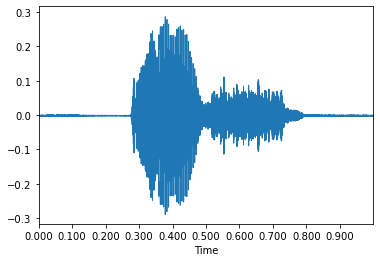

In [41]:
# 파일의 파형
librosa.display.waveplot(sound, sr=rate)
plt.show()

In [42]:
import IPython
IPython.display.Audio('./datasets/audio/yes-sample.wav')

In [43]:
# 디렉토리 이름 가져와 레이블로 생성
labels = [f for f in os.listdir(MY_PATH) if not os.path.isdir(f)]
labels = labels[:-1]
print(labels)

encoder = LabelEncoder()
encoder.fit(labels)

['go', 'happy', 'seven', 'stop', 'yes']


LabelEncoder()

In [44]:
# 오디오 파일 읽어 배열에 저장
def read_wave():
    global all_wave, all_label
    all_wave = []
    all_label = []

    for label in tqdm(labels):
        path = MY_PATH + '/' + label
        waves = [f for f in os.listdir(path)]

        for wav in waves:
            file = path + '/' + wav
            samples, rate = librosa.load(file, sr=16000)
            samples = librosa.resample(samples, orig_sr=rate, target_sr=MY_RATE)

            if (len(samples) == MY_RATE):
                all_wave.append(samples)
                all_label.append(label)

    all_label = encoder.transform(all_label)
    all_wave = np.array(all_wave).reshape(-1, MY_RATE, 1)

    print('Resampling 종료')
    print('전체 샘플링 수: ', len(all_wave))

    return all_wave, all_label

In [45]:
# 파일을 불러와 넘파이 배열로 만듦
# 이미 넘파이 저장한 파일 있으면 파일에서 불러옴
if os.path.exists('arrays.npy'):
    with open('arrays.npy', 'rb') as f:
        all_wave = np.load(f)
        all_label = np.load(f)

else:
    all_wave, all_label = read_wave()
    with open('arrays.npy', 'wb') as f:
        np.save(f, all_wave)
        np.save(f, all_label)

    print('데이터 파일 완성')

In [46]:
# 훈련, 검증데이터 분할
X_train, X_test, Y_train, Y_test = train_test_split(all_wave, all_label, train_size=MY_SPLIT, shuffle=True)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(711, 8000, 1) (178, 8000, 1) (711,) (178,)


In [47]:
# rnn 모델 구조 정의
inputs = Input(shape=(MY_RATE, 1))
x = BatchNormalization()(inputs)

# 첫 번째 합성곱
x = Conv1D(filters=8, kernel_size=13, padding='valid', strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)

# 두 번째 합성곱
x = Conv1D(filters=16, kernel_size=11, padding='valid', strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)

# 세 번째 합성곱
x = Conv1D(filters=32, kernel_size=9, padding='valid', strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)
x = BatchNormalization()(x)

# 첫 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True), merge_mode='sum')(x)

# 두 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True), merge_mode='sum')(x)

# 세 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=False), merge_mode='sum')(x)

# 은닉층
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)

# 출력층
outputs = Dense(units=len(labels), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization_3 (Batc  (None, 8000, 1)          4         
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 7988, 8)           112       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2662, 8)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2662, 8)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2652, 16)          1424

In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics='acc')

In [49]:
if os.path.exists('speech.h5'):
    model.load_weights('speech.h5')
else:
    begin = time()
    hist = model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)
    end = time()

    print(f'총 학습시간: {(end-begin): .2f}초')
    model.save_weights('speech.h5')

In [50]:
# 평가데이터를 이용한 모델 평가
scores = model.evaluate(x=X_test, y=Y_test, verbose=1)
print(f'평가데이터의 정확도: {scores[1]:.2f}')

6/6 [==============================] - 4s 273ms/step - loss: 0.1771 - acc: 0.9438
평가데이터의 정확도: 0.94


In [51]:
# 데이터 입력 후 예측 결과 출력 함수
def audio_to_text(audio):
    pred = model.predict(audio.reshape(1, MY_RATE, 1))
    index = np.argmax(pred[0])
    return labels[index]

In [58]:
# 예제 파일 중 임의의 파일 하나 선택
rand_dir = random.choice(os.listdir(MY_PATH)[:-1])
print(rand_dir)

rand_path = random.choice(os.listdir(MY_PATH + '/' + rand_dir))
picked = os.path.join(MY_PATH, rand_dir, rand_path)
picked_label = rand_dir
print(picked)

IPython.display.Audio(picked)

seven
./datasets/audio\seven\e7ea8b76_nohash_2.wav


In [59]:
# 선택한 파일 불러와 리샘플링 후 예측 결과 출력
y, sr = librosa.load(picked, sr=16000)
sample = librosa.resample(y, orig_sr=sr, target_sr=MY_RATE)
sample = pad_sequences(np.array(sample).reshape(1, -1), maxlen=MY_RATE, padding='post', dtype=float)
sample = np.array(sample).reshape(-1, MY_RATE, 1)
print(audio_to_text(sample))

seven
